In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19,VGG16,ResNet50
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model # to save the model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed
import wandb
from wandb.keras import WandbCallback
import requests
import urllib
from io import BytesIO
from PIL import Image

In [2]:
categories = ['Baby','Home Improvement','Pet Supplies','Kitchen & Dining',
              'Automotive','Computers','Cell Phones & Accessories',
              'Health & Personal Care','Beauty','Grocery & Gourmet Food',
              'Patio, Lawn & Garden','Arts, Crafts & Sewing',
              'Musical Instruments','Home &amp; Kitchen','Clothing',
              'Jewelry','Electronics','Camera & Photo','Watches','Shoes']

In [3]:
image_array = np.load('../input/data-amazon-product-image-250-new/image_array.npy')
label_array = np.load('../input/data-amazon-product-image-250-new/label_array.npy')

In [4]:
train_images, test_images, train_labels, test_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels=train_test_split(train_images, train_labels,
                                                                      test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3592
Number of validation samples : 899
Number of       test samples : 500


In [5]:
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001
RANDOM_STATE = 42
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
METRICS = ["accuracy"]

In [6]:
def get_resnet(categories):
    conv_block = tf.keras.applications.resnet.ResNet50(include_top = False, weights = "imagenet")
    output = tf.keras.layers.GlobalAveragePooling2D()(conv_block.output)
    output = tf.keras.layers.Dense(categories, activation = "softmax")(output)
    model = tf.keras.Model(inputs = [conv_block.input], outputs = [output])
    return model

model = get_resnet(len(categories))
config_defaults = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "loss": LOSS,
  "random_state": RANDOM_STATE,
  "optimizer": OPTIMIZER,
  "metrics": METRICS
}
# wandb.init(project="Dataset_Classification", id="resnet50", config = config_defaults)
model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ["accuracy"])

2022-10-14 06:33:07.797411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:33:07.900389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:33:07.901220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:33:07.902817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [7]:
history = model.fit(train_images, train_labels,
                    validation_data = (val_images,  val_labels), 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights = True)] )

2022-10-14 06:33:13.617173: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-14 06:33:16.151086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-14 06:33:17.883794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-10-14 06:33:24.055830: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - ETA: 0s - loss: 2.2195 - accuracy: 0.3561

2022-10-14 06:33:53.743999: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.
2022-10-14 06:33:54.404976: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.


225/225 [==============================] - 40s 125ms/step - loss: 2.2195 - accuracy: 0.3561 - val_loss: 3.1551 - val_accuracy: 0.0545
Epoch 2/20
225/225 [==============================] - 25s 112ms/step - loss: 1.0397 - accuracy: 0.6968 - val_loss: 3.1628 - val_accuracy: 0.1068
Epoch 3/20
225/225 [==============================] - 25s 110ms/step - loss: 0.3920 - accuracy: 0.9112 - val_loss: 3.3290 - val_accuracy: 0.2981
Epoch 4/20
225/225 [==============================] - 24s 109ms/step - loss: 0.1059 - accuracy: 0.9875 - val_loss: 2.5084 - val_accuracy: 0.4127
Epoch 5/20
225/225 [==============================] - 25s 109ms/step - loss: 0.0379 - accuracy: 0.9967 - val_loss: 2.2564 - val_accuracy: 0.4872
Epoch 6/20
225/225 [==============================] - 25s 109ms/step - loss: 0.0290 - accuracy: 0.9955 - val_loss: 2.3060 - val_accuracy: 0.5072
Epoch 7/20
225/225 [==============================] - 24s 109ms/step - loss: 0.0514 - accuracy: 0.9894 - val_loss: 2.7771 - val_accuracy: 0.4

In [8]:
print("Loss of the model is - " , model.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(test_images, test_labels)[1]*100 , "%")

2022-10-14 06:38:05.319910: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301056000 exceeds 10% of free system memory.


16/16 [==============================] - 1s 72ms/step - loss: 2.4764 - accuracy: 0.5000
Loss of the model is -  2.476379632949829
16/16 [==============================] - 1s 56ms/step - loss: 2.4764 - accuracy: 0.5000
Accuracy of the model is -  50.0 %


ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

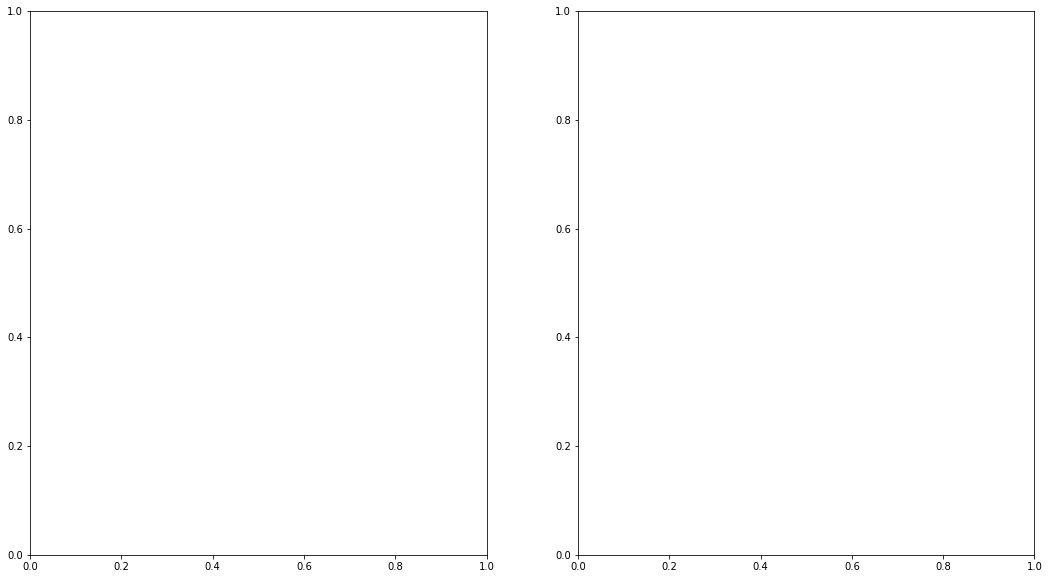

In [9]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(18,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(categories)):
    if(test_labels[i] == predictions[i]):
        prop_class.append(i)
    if(len(categories)==8):
        break

i=0
for i in range(len(categories)):
    if(test_labels[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
count=0
fig,ax=plt.subplots(3,2)
fig.set_size_inches(10,10)
for i in range (3):
    for j in range (2):
        ax[i,j].imshow(test_images[prop_class[count]])
        ax[i,j].set_title("Predicted : "+ categories[predictions[prop_class[count]]] +"\n"+"Actual : "+ categories[test_labels[prop_class[count]]])
        plt.tight_layout()
        count+=1

In [ ]:
count=0
fig,ax=plt.subplots(3,2)
fig.set_size_inches(10,10)
for i in range (3):
    for j in range (2):
        ax[i,j].imshow(test_images[mis_class[count]])
        ax[i,j].set_title("Predicted : "+categories[predictions[mis_class[count]]]+"\n"+"Actual : "+categories[test_labels[mis_class[count]]])
        plt.tight_layout()
        count+=1